In [1]:
import magnonRPA as rpa
import numpy as np

from matplotlib import pyplot as plt 
from matplotlib import colors as mclr
from matplotlib import colormaps as cmaps

import time

### Plotting settings 
#plt.rc('figure', dpi=100)
#plt.rc('figure',figsize=(4,1.7))
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

saveFigs = False ### Option to save figures or not 

figDirectory = "../figures/" ### Figures are stored in this folder
dataDirectory = "../data/" ### Data is loaded from and stored to this folder


## Load in spectral function

In [62]:
### Location of hole spectral functions
holesDirectory = dataDirectory+"hole_spectra/05052025/5ksamples/" 
holesFile = holesDirectory+"jon_request_0.05" 

#holesFile = dataDirectory+"/hole_spectra/03252025/Hole_Spectral_functionJz0.05_alfa0.999_Nx20_Ny20" 

### Load in spectral function
kxs,kys,ws,A = rpa.load_hole_spectrum(holesFile)
### If this is true we will use a fictious box spectral function
useBox = False

if useBox:
    W = 2.*rpa.t
    Nkx = 40
    Nky = 40
    Nw = 33
    
    kxs = np.linspace(0.,2.*np.pi,Nkx,endpoint=False)
    kys = np.linspace(0.,2.*np.pi,Nky,endpoint=False)
    ws = np.linspace(-10.,10.,Nw)
    A = rpa.gen_box_A(kxs,kys,ws,W)
    
### Useful to make vectorized grids and keep track of sizes of arrays
kxvs,kyvs,wvs = np.meshgrid(kxs,kys,ws)
Nkx = len(kxs)
Nky = len(kys)
Nw = len(ws)
dw = ws[1]-ws[0]
print("Nkx,Nky,Nw: ", Nkx,Nky,Nw)
print("dw: ",dw)

KK_matrix = rpa.KK_matrix(ws)

Nkx,Nky,Nw:  40 40 5000
dw:  0.004000800160032014


## Plot hole spectrum

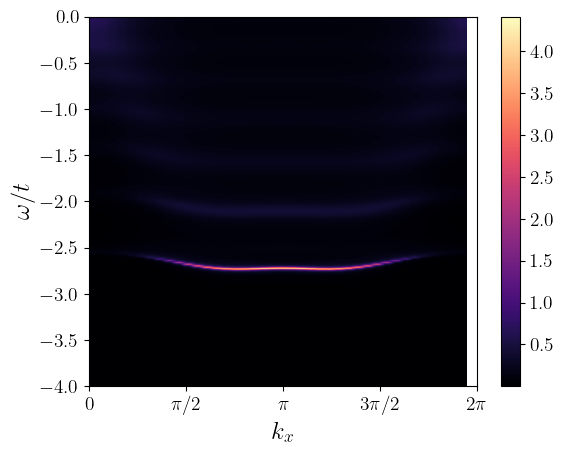

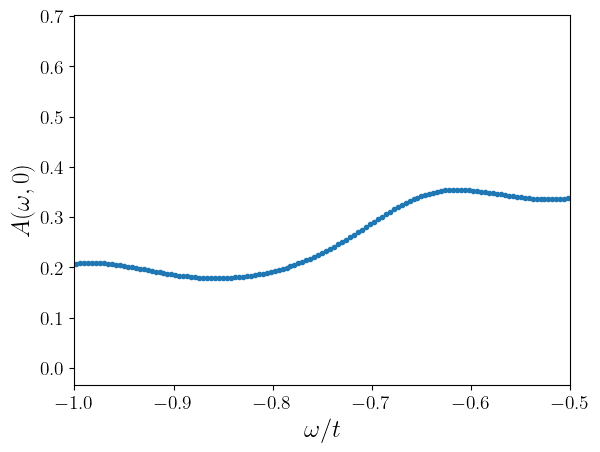

In [63]:
### Plot spectral function for a cut
plt.imshow(np.transpose(A[:,0,:]),extent=[kxs[0],kxs[-1],ws[0],ws[-1]],origin='lower',cmap='magma',aspect=1.5)
plt.colorbar()
plt.ylim(-4.*rpa.t,-0.*rpa.t)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$\omega/t$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

plt.plot(ws/rpa.t,A[0,0,:],'.')
plt.ylabel(r'$A(\omega,0)$')
plt.xlabel(r'$\omega/t$')
plt.xlim(-1,-.5)
plt.show()

## Set parameters and computing doping

In [64]:
T = 0.001*rpa.t ### temperature
U = 8.*rpa.t ### Hubbard U (used to compute J)
J = 4.*rpa.t**2/U ### Superexchange J
mu = -2.6*rpa.t ### Chemical potential (controls doping)
#mu = -1.55*rpa.t
#mu = -0.82*rpa.t
#mu = -0.5*rpa.t

### Compute doping
delta = rpa.calc_density(kxs,kys,ws,A,mu,T)
print("Hole doping: {d:0.2%}".format(d=delta))
print("J/t used in LSWT: {jt:0.2f}".format(jt=J/rpa.t))

Hole doping: 9.99%
J/t used in LSWT: 0.50


## Now we compute the RPA kernel and magnon propagator

In [65]:
### Calculate RPA spectra from hole spectra 
t0 = time.time()
ImPi = rpa.calc_ImPi(kxs,kys,ws,A,mu,T)
if useBox: ImPi_analytic = rpa.box_ImPi(kxs,kys,ws,W,mu)
t1 = time.time()
Pi = rpa.Kramers_Kronig_precomputed(KK_matrix,ImPi)
if useBox: Pi_analytic = rpa.Kramers_Kronig_precomputed(KK_matrix,ImPi)
t2 = time.time()
magnon_kernel=rpa.RPA_kernel(kxs,kys,ws,Pi,J)
magnon_propagator = rpa.RPA_propagator(kxs,kys,ws,Pi,J)
if useBox: magnon_propagator_analytic = rpa.RPA_propagator(kxs,kys,ws,Pi_analytic,J)
t3 = time.time()
spectrum = rpa.RPA_spectrum(kxs,kys,ws,magnon_propagator)
if useBox: spectrum_analytic = rpa.RPA_spectrum(kxs,kys,ws,magnon_propagator_analytic)
t4 = time.time()
sum_rule = np.sum(spectrum,axis=-1)*dw 
if useBox: sum_rule_analytic = np.sum(spectrum_analytic,axis=-1)*dw 

print("Time for RPA: ",t1-t0,"s")
print("Time for Kramers-Kronig: ",t2-t1,"s")
print("Time for forming and inverting kernel: ",t3-t2,"s")
print("Time for computing spectrum: ",t4-t3,"s")

Time for RPA:  22.570396900177002 s
Time for Kramers-Kronig:  7.224786996841431 s
Time for forming and inverting kernel:  104.93894505500793 s
Time for computing spectrum:  0.9002821445465088 s


## Plotting and various diagonostics

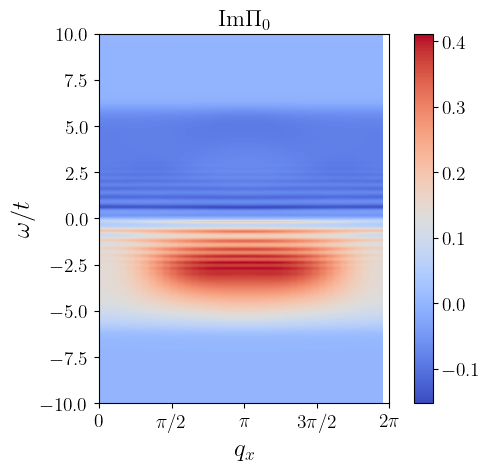

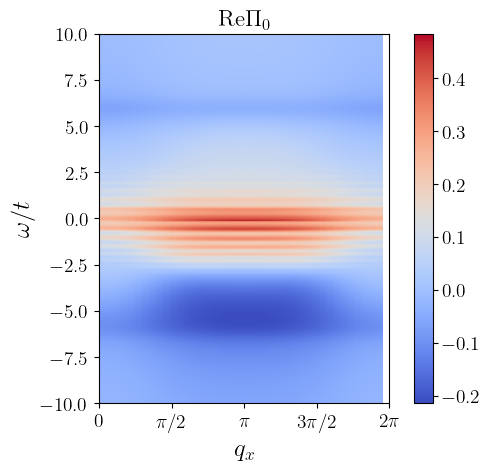

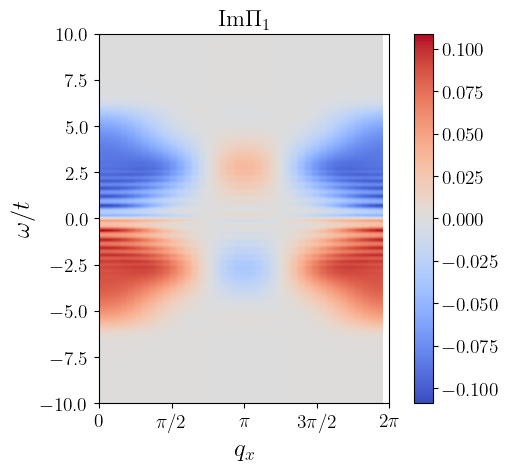

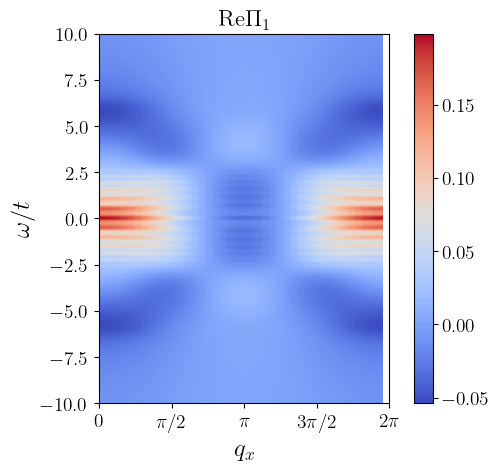

In [66]:
### Frequency dependence of Pi for kx cut 
labels = [ r'$\Pi_0$',r'$\Pi_1$']
for i in range(2):
    plt.imshow(np.transpose(np.imag(Pi[i,:,5,:])),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
    plt.xlabel(r'$q_x$')
    plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.ylabel(r'$\omega/t$')
    plt.colorbar()
    plt.title(r'Im'+labels[i])
    plt.show()
    
    plt.imshow(np.transpose(np.real(Pi[i,:,5,:])),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
    plt.xlabel(r'$q_x$')
    plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.ylabel(r'$\omega/t$')
    plt.colorbar()
    plt.title(r'Re'+labels[i])
    plt.show()

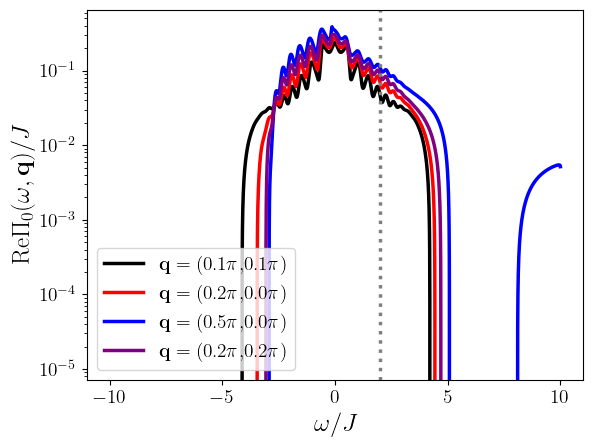

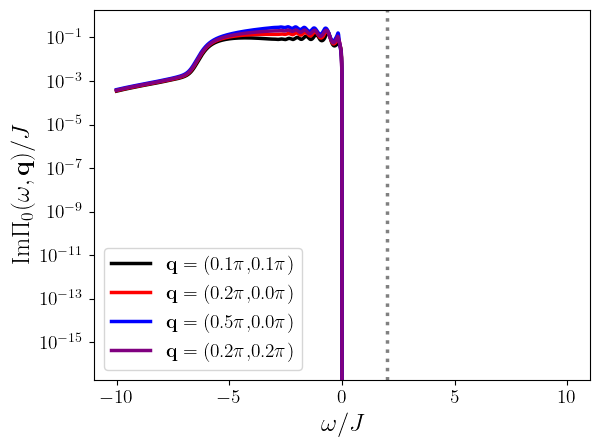

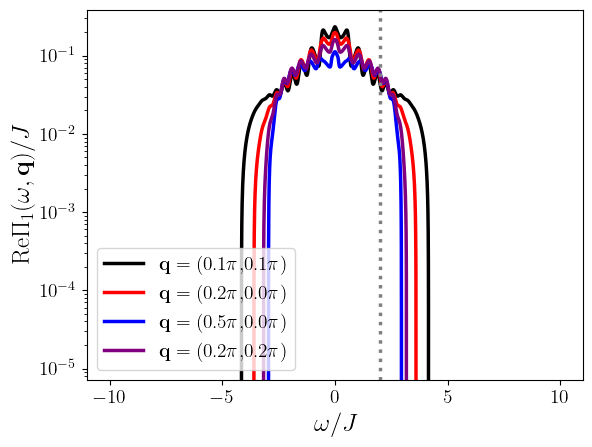

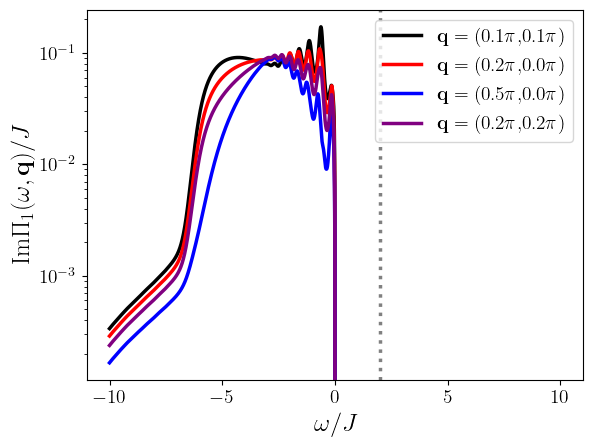

In [72]:
### Frequency-momentum cuts of RPA function
#indices = [ [1,1],[20,0],[10,10],[15,15]]
indices = [ [1,1],[5,0],[10,0],[5,5]]
#clrs = cmaps['Reds'](np.linspace(0.4,1.,len(indices)))
clrs = ['black','red','blue','purple']
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]
plot_labels =  [ r'$\Pi_0$',r'$\Pi_1$']

### Frequency cuts of Pi for magnons
for a in range(2):
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(rpa.gen_magnon_freqs(ws)/rpa.t,np.real(Pi[a,i[0],i[1],:])/rpa.t,label=label_strings[j],color=clrs[j])
    #plt.xlim(-5.*rpa.t,5.*rpa.t)
    plt.axvline(2.,color='gray',linestyle='dotted')
    plt.xlabel(r'$\omega/J$')
    plt.ylabel(r'Re'+plot_labels[a]+r'$(\omega,\mathbf{q})/J$')
    plt.legend()
    plt.yscale('log')
    plt.show()
    
    
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(rpa.gen_magnon_freqs(ws)/rpa.t,np.imag(Pi[a,i[0],i[1],:])/rpa.t,label=label_strings[j],color=clrs[j])
    #plt.xlim(-5.*rpa.t,5.*rpa.t)
    plt.axvline(2.,color='gray',linestyle='dotted')
    plt.xlabel(r'$\omega/J$')
    plt.ylabel(r'Im'+plot_labels[a]+r'$(\omega,\mathbf{q})/J$')
    plt.legend()
    plt.yscale('log')
    plt.show()
    

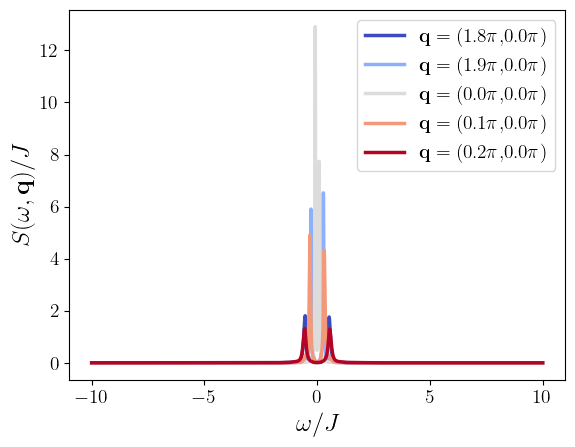

In [71]:
### Spectral function frequency cuts

indices = [ [-4,0],[-2,0],[0,0],[2,0],[4,0]]
clrs = cmaps['coolwarm'](np.linspace(0.,1.,len(indices)))
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]

for j in range(len(indices)):
    i = indices[j]
    plt.plot(rpa.gen_magnon_freqs(ws)/rpa.t, spectrum[i[0],i[1],:],label=label_strings[j],color=clrs[j])
#plt.xlim(-2.,2.)
#plt.axvline(2.,color='gray',linestyle='dotted')
plt.xlabel(r'$\omega/J$')
plt.ylabel(r'$S(\omega,\mathbf{q})/J$')
plt.legend()
#plt.yscale('log')
plt.show()


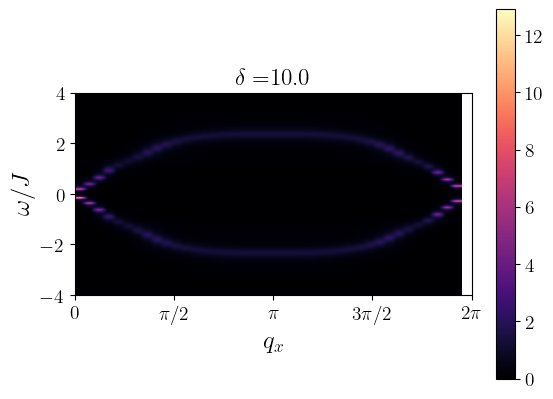

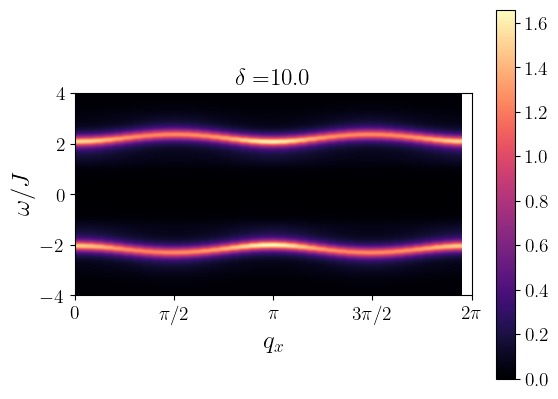

In [69]:
#scale = mclr.LogNorm()
#scale = mclr.Normalize(0.,10.)
scale = None

plt.imshow(np.transpose(spectrum[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0]/J,ws[-1]/J],cmap='magma',aspect=.4,norm=scale)
plt.ylabel(r'$\omega/J$')
plt.ylim(-4,4)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
plt.title(r'$\delta = $'+"{:0.1%}".format(delta))
if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
plt.show()


plt.imshow(np.transpose(spectrum[:,10,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0]/J,ws[-1]/J],cmap='magma',aspect=.4,norm=scale)
plt.ylabel(r'$\omega/J$')
plt.ylim(-4,4)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
plt.title(r'$\delta = $'+"{:0.1%}".format(delta))
if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
plt.show()

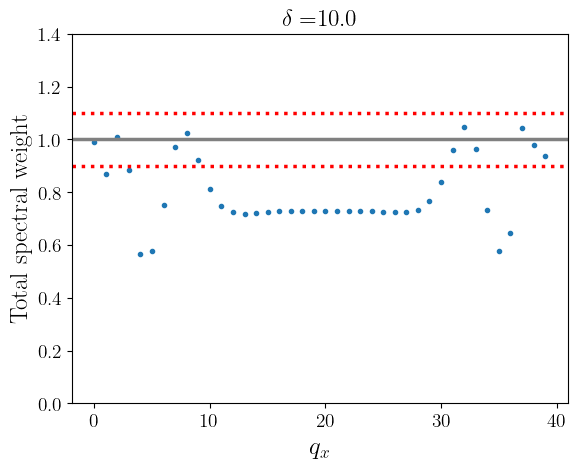

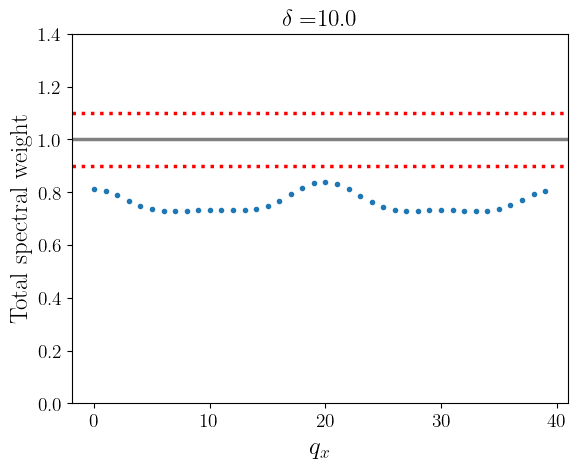

In [70]:
plt.plot(sum_rule[:,0],'.')
plt.axhline(1.,linestyle='solid',color='gray')
plt.axhline(0.9,linestyle='dotted',color='red')
plt.axhline(1.1,linestyle='dotted',color='red')
plt.ylim(0.,1.4)
plt.xlabel(r'$q_x$')
plt.ylabel(r'Total spectral weight')
plt.title(r'$\delta = $'+"{:0.1%}".format(delta))
plt.show()

plt.plot(sum_rule[:,10],'.')
plt.axhline(1.,linestyle='solid',color='gray')
plt.axhline(0.9,linestyle='dotted',color='red')
plt.axhline(1.1,linestyle='dotted',color='red')
plt.ylim(0.,1.4)
plt.xlabel(r'$q_x$')
plt.ylabel(r'Total spectral weight')
plt.title(r'$\delta = $'+"{:0.1%}".format(delta))
plt.show()
